In [2]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Index(['COBERTURA', 'ID_ENTIDAD', 'ID_MUNICIPIO', 'ANIO', 'MES', 'ID_HORA',
       'ID_MINUTO', 'ID_DIA', 'DIASEMANA', 'URBANA', 'SUBURBANA', 'TIPACCID',
       'AUTOMOVIL', 'CAMPASAJ', 'MICROBUS', 'PASCAMION', 'OMNIBUS', 'TRANVIA',
       'CAMIONETA', 'CAMION', 'TRACTOR', 'FERROCARRI', 'MOTOCICLET',
       'BICICLETA', 'OTROVEHIC', 'CAUSAACCI', 'CAPAROD', 'SEXO', 'ALIENTO',
       'CINTURON', 'ID_EDAD', 'CONDMUERTO', 'CONDHERIDO', 'PASAMUERTO',
       'PASAHERIDO', 'PEATMUERTO', 'PEATHERIDO', 'CICLMUERTO', 'CICLHERIDO',
       'OTROMUERTO', 'OTROHERIDO', 'NEMUERTO', 'NEHERIDO', 'CLASACC',
       'ESTATUS'],
      dtype='object')
Algunas fechas no se pudieron convertir. Revisando registros problemáticos...
         ANIO  MES  ID_DIA  ID_HORA  ID_MINUTO
356315   2022    1     1.0        2         48
356316   2022    1     1.0        3         45
356317   2022    1     1.0        4          0
356318   2022    1     1.0        4         15
356319   2022    1     1.0        5         56
..

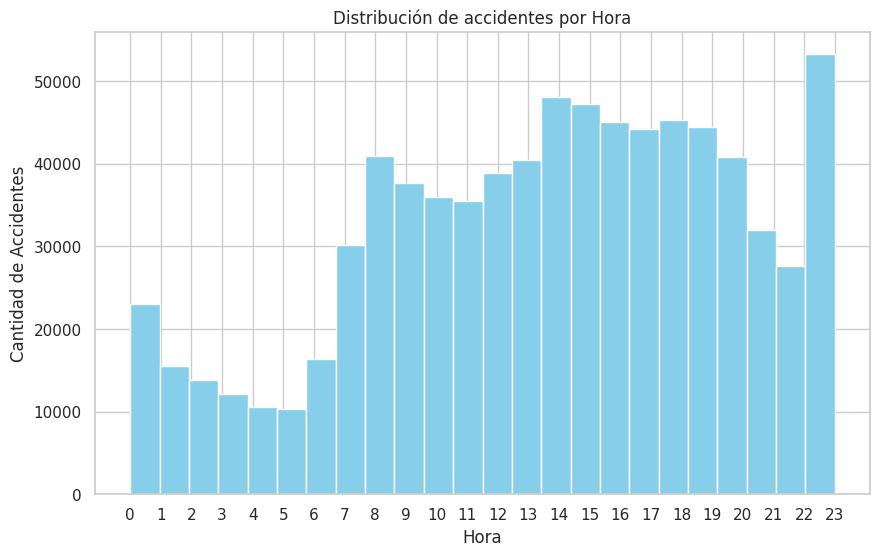

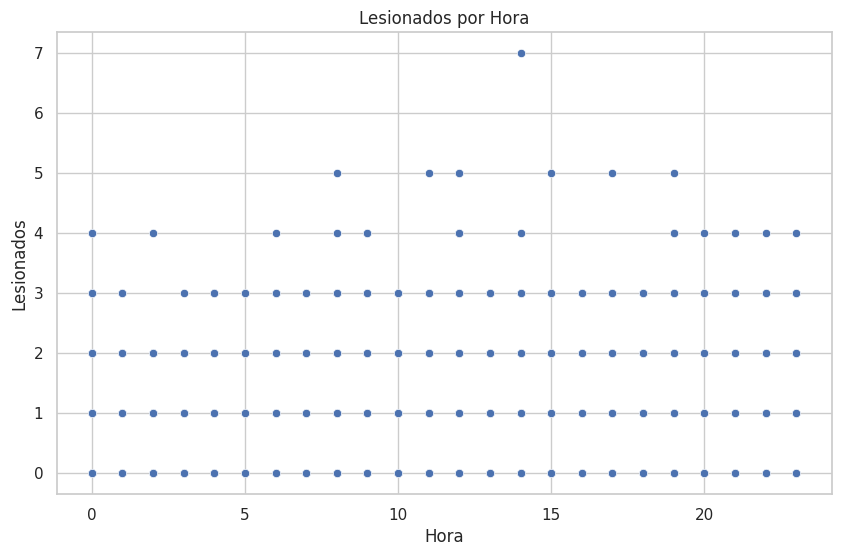

No hay datos para graficar la tendencia mensual de accidentes.


In [7]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ajuste de estilo para gráficos
sns.set(style="whitegrid")

# Paso 1: Cargar los datos de los últimos 3 años
years = [2021, 2022, 2023]
dataframes = []

for year in years:
    df = pd.read_csv(f'atus_anual_csv/conjunto_de_datos/atus_anual_{year}.csv', encoding='utf-8')
    dataframes.append(df)

# Concatenar los DataFrames de los tres años en uno solo
data = pd.concat(dataframes, ignore_index=True)


print(data.columns)

# Paso 2: Crear la columna de fecha
# Asegurarse de que las columnas relevantes son numéricas y no tienen valores nulos
data[['ANIO', 'MES', 'ID_DIA', 'ID_HORA', 'ID_MINUTO']] = data[['ANIO', 'MES', 'ID_DIA', 'ID_HORA', 'ID_MINUTO']].apply(pd.to_numeric, errors='coerce')
data.dropna(subset=['ANIO', 'MES', 'ID_DIA', 'ID_HORA', 'ID_MINUTO'], inplace=True)

# Filtrar datos incorrectos: horas no válidas (0-23) y minutos no válidos (0-59)
data = data[(data['ID_HORA'].between(0, 23)) & (data['ID_MINUTO'].between(0, 59))]

# Crear la columna de fecha en el formato correcto
data['date'] = pd.to_datetime(data[['ANIO', 'MES', 'ID_DIA', 'ID_HORA', 'ID_MINUTO']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H-%M', errors='coerce')

# Verificar si hay errores en la conversión
if data['date'].isnull().any():
    print("Algunas fechas no se pudieron convertir. Revisando registros problemáticos...")
    print(data[data['date'].isnull()][['ANIO', 'MES', 'ID_DIA', 'ID_HORA', 'ID_MINUTO']])

# Paso 3: Crear las columnas "Área" y "Zona"
data['Área'] = data.apply(lambda row: 'Urbana' if row['URBANA'] == 1 else 'Suburbana', axis=1)

#paso 4 Zopn a
data['Zona'] = data.apply(lambda row: 'Urbana' if row['URBANA'] == 1 else 'Suburbana' if row['SUBURBANA'] == 1 else 'Desconocida', axis=1)

#Paso 5
# Eliminar las columnas "URBANA" y "SUBURBANA"
data.drop(columns=['URBANA', 'SUBURBANA'], inplace=True, errors='ignore')

# Paso 6 Municipio con más meses sin accidentes
data['Mes'] = data['date'].dt.month
no_accidentes_por_mes = data.groupby(['ID_ENTIDAD', 'ID_MUNICIPIO', 'Mes']).size().reset_index(name='accidentes')
meses_sin_accidentes = no_accidentes_por_mes[no_accidentes_por_mes['accidentes'] == 0]

if not meses_sin_accidentes.empty:
    mas_meses_sin_accidentes = meses_sin_accidentes.groupby(['ID_ENTIDAD', 'ID_MUNICIPIO']).size().idxmax()
    print(mas_meses_sin_accidentes)
else:
    mas_meses_sin_accidentes = None
    print("No hay municipios con meses sin accidentes.")

# Paso 7 Resumen de accidentes del último año
ultimo_anio = data[data['ANIO'] == 2023]
resumen_accidentes = ultimo_anio['TIPACCID'].value_counts(normalize=True) * 100
print(resumen_accidentes)

# Paso 4.3: Muertos y lesionados en los últimos 3 años
total_muertos = data['CONDMUERTO'].sum() + data['PASAMUERTO'].sum() + data['PEATMUERTO'].sum() + data['CICLMUERTO'].sum()
total_lesionados = data['CONDHERIDO'].sum() + data['PASAHERIDO'].sum() + data['PEATHERIDO'].sum() + data['CICLHERIDO'].sum()
print(f"Total de muertos en los últimos 3 años: {total_muertos}" , f"Total de lesionados en los últimos 3 años: {total_lesionados}")

# Paso 4.4: Comparación de accidentes año contra año
accidentes_por_anio = data.groupby('ANIO').size()
variacion_anual = accidentes_por_anio.pct_change() * 100
print("Comparacion de accidentes año contra año:", variacion_anual)

# Paso 5.1: Histograma de accidentes por Hora
plt.figure(figsize=(10, 6))
plt.hist(data['ID_HORA'], bins=24, color='skyblue')
plt.title('Distribución de accidentes por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(range(0, 24))
plt.show()

# Paso 5.2: Gráfico de Dispersión (Ejemplo: ID_HORA vs. lesionados)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ID_HORA', y='CONDHERIDO', data=data)
plt.title('Lesionados por Hora')
plt.xlabel('Hora')
plt.ylabel('Lesionados')
plt.show()

# Paso 5.3: Gráfico de Líneas (Evolución mensual de accidentes)
data['Fecha_Mensual'] = data['date'].dt.to_period('M')
accidentes_mensuales = data.groupby('Fecha_Mensual').size()

# Verificar si hay datos para graficar
if not accidentes_mensuales.empty:
    plt.figure(figsize=(12, 6))
    accidentes_mensuales.plot(kind='line', marker='o', color='coral')
    plt.title('Tendencia Mensual de Accidentes')
    plt.xlabel('Fecha')
    plt.ylabel('Número de Accidentes')
    plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor visualización
    plt.grid()  # Agregar una cuadrícula para facilitar la lectura
    plt.show()
else:
    print("No hay datos para graficar la tendencia mensual de accidentes.")


In [7]:
ultimo_anio = data[data['ANIO'] == 2023]  # Cambia el año si es necesario

# Paso 2: Resumir accidentes por tipo
resumen_accidentes = ultimo_anio['TIPACCID'].value_counts(normalize=True) * 100

# Paso 3: Convertir a DataFrame para mejor visualización
resumen_df = resumen_accidentes.reset_index()
resumen_df.columns = ['Tipo de Accidente', 'Porcentaje']

# Paso 4: Mostrar resultados
print("Resumen de accidentes del último año por tipo:")
print(resumen_df)
total_muertos = data['CONDMUERTO'].sum()  # Asumiendo que 'CONDMUERTO' es la columna de muertos
total_lesionados = data['CONDHERIDO'].sum()  # Asumiendo que 'CONDHERIDO' es la columna de lesionados

print(f'Total de muertos en los últimos 3 años: {total_muertos}')
print(f'Total de lesionados en los últimos 3 años: {total_lesionados}')

# Paso 2: Comparación de accidentes año contra año
accidentes_por_anio = data.groupby('ANIO').size()

# Calcular variación anual
variacion_anual = accidentes_por_anio.pct_change() * 100

# Mostrar resultados
comparacion = pd.DataFrame({
    'Accidentes': accidentes_por_anio,
    'Variación (%)': variacion_anual
})

print("\nComparación de accidentes por año:")
print(comparacion)


Resumen de accidentes del último año por tipo:
                          Tipo de Accidente  Porcentaje
0         ColisiÃ³n con vehÃ­culo automotor   58.621142
1                 ColisiÃ³n con motocicleta   14.476902
2                 ColisiÃ³n con objeto fijo   11.152545
3                          Certificado cero    3.928213
4   ColisiÃ³n con peatÃ³n (atropellamiento)    2.988518
5                                 Volcadura    2.886657
6                         Salida del camino    2.579812
7                                      Otro    1.463625
8                    ColisiÃ³n con ciclista    0.990374
9                        CaÃ­da de pasajero    0.490901
10                     ColisiÃ³n con animal    0.258687
11                                 Incendio    0.096062
12                ColisiÃ³n con ferrocarril    0.066563
Total de muertos en los últimos 3 años: 5391
Total de lesionados en los últimos 3 años: 94952

Comparación de accidentes por año:
      Accidentes  Variación (%)
ANIO   